# Implementación algoritmo SARSA en robótica móvil

## Inteligencia Artificial
### Grado en Ingeniería Informática - Ingeniería del Software
### Curso 2023/2024
### Alumno 1: David Fuentelsaz Rodríguez
### Alumno 2: Miguel Galán Lerate


Este fichero contiene nuestra implementación del algoritmo SARSA aplicado a un problema de aprendizaje por refuerzo en robótica móvil, donde un robot con ruedas debe planificar una ruta en un entorno con obstáculos.

Como recordatorio, SARSA (State Action Reward State Action) es un algoritmo de aprendizaje por refuerzo que permite a un agente interactuar con un entorno y, mediante ensayo y error, aprender cuáles son las mejores acciones para realizar en cada estado (aprendizaje de una política óptima en un entorno de decisión de Markov). El algoritmo utiliza una tabla (Q-table) donde almacena los valores acumulados de recompensa para cada par estado-acción. A medida que se ejecutan iteraciones del algoritmo, el agente actualiza su tabla Q basándose en sus experiencias con el entorno. 

Además, es importante destacar que SARSA, a diferencia de Q-Learning, sigue un enfoque denominado 'on-policy', lo que significa que la actualización de su función de utilidad (Q-values) se realiza a partir de la política seguida por el agente. Esto permite al agente aprender qué acciones son mejores en cada estado, teniendo en cuenta su comportamiento actual.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# El siguiente código lee el goal y el mapa del fichero

def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz),(numeros[0],numeros[1])


In [3]:
# Creamos un array que almacene el mapa que se le pase como parámetro a la función lee_mapa, definida anteriormente

mapa,destino = lee_mapa("../../data/map.txt")
print(mapa)
print(destino)


[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1

In [4]:
def visualiza_mapa():
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5)
    plt.ylim(-0.5, len(mapa) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))
   
    

El mapa para el problema es el siguiente (el punto rojo define la casilla objetivo):

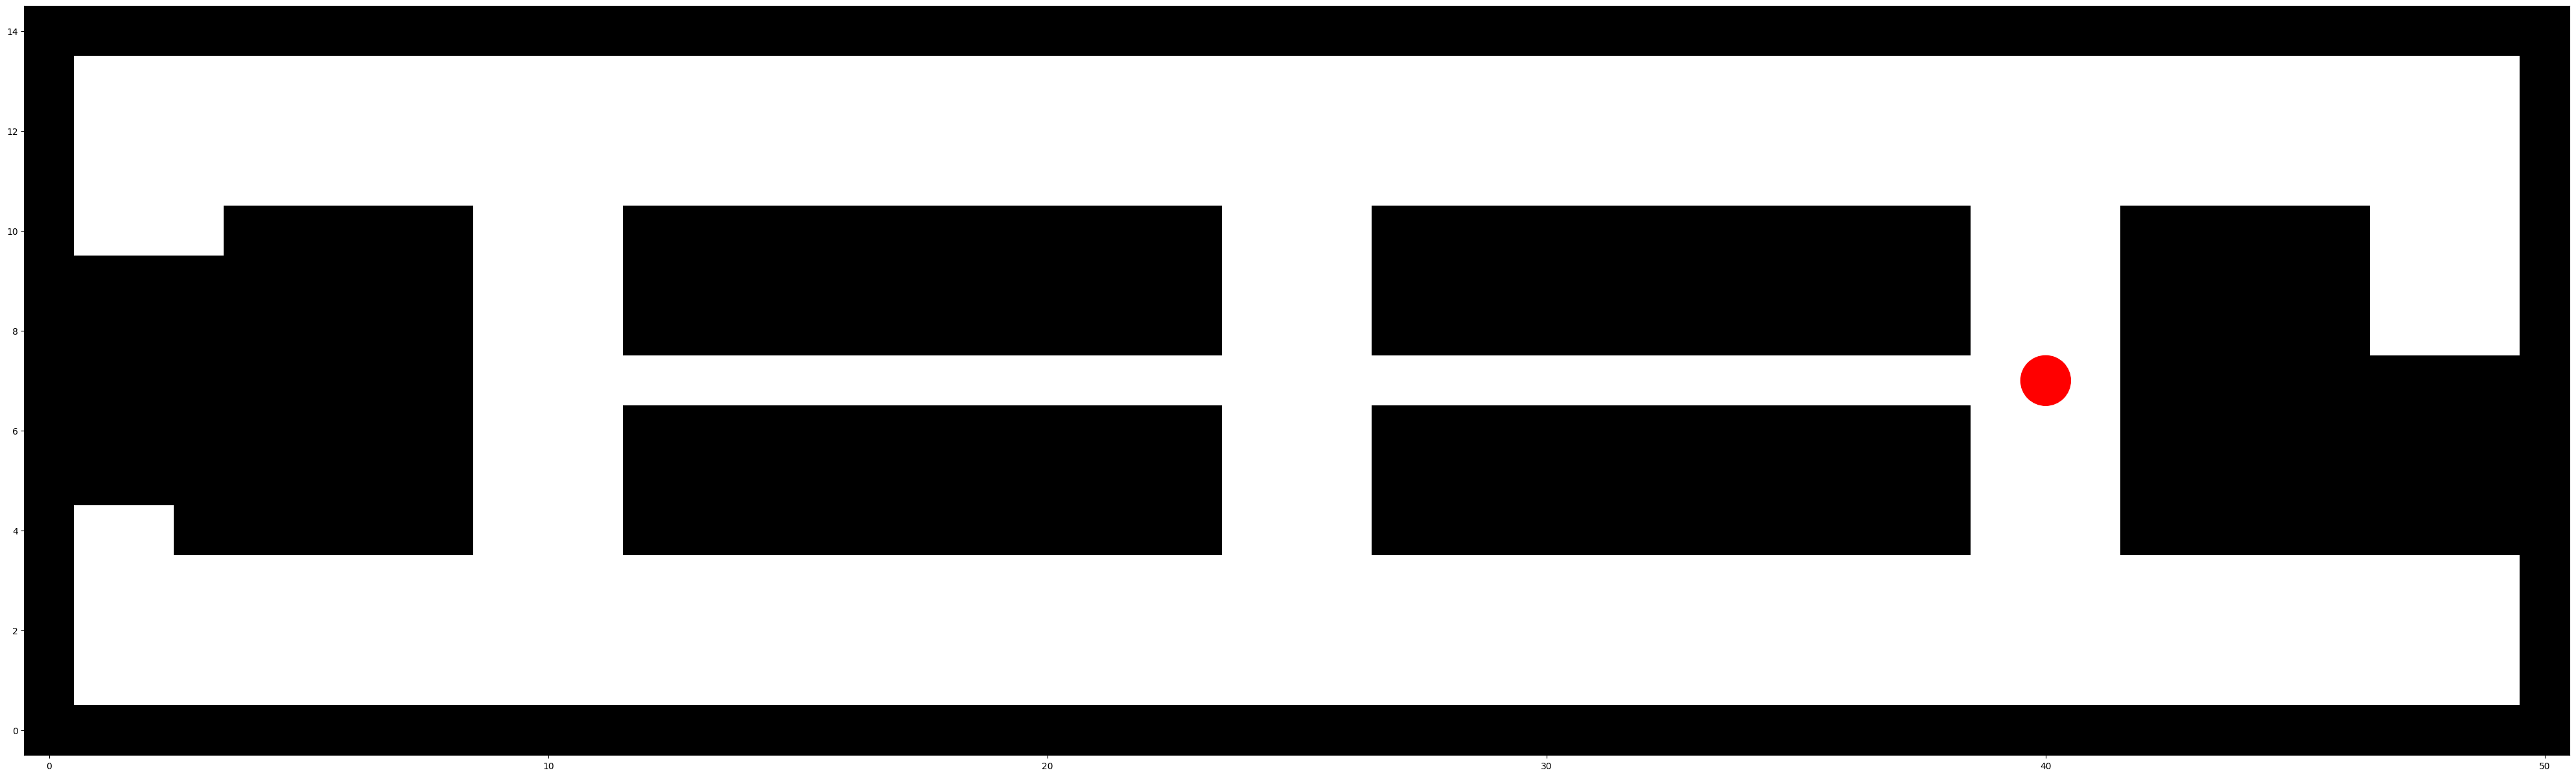

In [5]:
visualiza_mapa()


Los estados del problema serán las casillas del mapa (incluso las que tienen obstáculos), el siguiente código extrae los estados como una lista de tuplas (x,y)

In [6]:
nav_estados = []
for i in range(0,mapa.shape[1]):
    for j in range(0,mapa.shape[0]):
        nav_estados.append(tuple([i,j]))
len(nav_estados)

765

A continuación definimos las posibles acciones de movimiento que puede tomar el agente. En este caso tenemos una acción por cada movimiento disponible junto con la acción 'esperar', con la cual el robot quedará en el mismo estado (casilla) tras aplicarla.

In [7]:
nav_acciones = ['esperar','N','NE','E','SE','S','SO','O','NO']


Las siguientes funciones definidas son las que intervendrán en las iteraciones del algoritmo Q-Learnig. La funcionalidad de cada una de ellas viene explicada con comentarios.

In [8]:
def hay_colision(estado):
    # Verifica si hay una colisión en la casilla especificada por estado
    return mapa[estado[1], estado[0]] == 1

def aplica_accion(estado, accion):
    # Si hay colisión en el estado actual, el estado no cambia pues no hay moviemientos posibles
    if hay_colision(estado):
        return estado
    x = estado[0]
    y = estado[1]

    # Actualiza las coordenadas x, y según la acción tomada
    if accion == 'N':
        y += 1
    elif accion == 'S':
        y -= 1
    elif accion == 'E':
        x += 1
    elif accion == 'O':
        x -= 1
    elif accion == 'NE':
        y += 1
        x += 1
    elif accion == 'SE':
        y -= 1
        x += 1
    elif accion == 'SO':
        y -= 1
        x -= 1
    elif accion == 'NO':
        y += 1
        x -= 1
    return x, y

def obtiene_posibles_errores(accion):
    # Devuelve una lista de posibles acciones erróneas que podrían ocurrir al ejecutar la acción dada, debido al
    # efecto estocástico de realizar las acciones.
    if accion == 'N':
        errores = ['NE', 'NO']
    elif accion == 'S':
        errores = ['SE', 'SO']
    elif accion == 'E':
        errores = ['NE', 'SE']
    elif accion == 'O':
        errores = ['NO', 'SO']
    elif accion == 'NE':
        errores = ['N', 'E']
    elif accion == 'NO':
        errores = ['N', 'O']
    elif accion == 'SE':
        errores = ['S', 'E']
    elif accion == 'SO':
        errores = ['S', 'O']
    else:
        errores = []
    return errores
    
def estados_sin_obstaculos():
    # Devuelve una lista de estados que no tienen obstáculos
    return [estado for estado in nav_estados if not hay_colision(estado)]

def escoger_accion(estado, epsilon):
    # Si el estado no está en la tabla Q, inicializa sus valores a ceros
    if estado not in Q_table:
        Q_table[estado] = np.zeros(len(nav_acciones))
    
    # Usa una política epsilon-greedy para seleccionar una acción
    if np.random.rand() < epsilon:
        # Selecciona una acción aleatoria con probabilidad epsilon
        accion = np.random.randint(0, len(nav_acciones))
    else:
        # Selecciona la mejor acción conocida con probabilidad 1 - epsilon
        accion = np.argmax(Q_table[estado])
    return accion

def obtener_politica(Q):
    # Genera una política basada en la tabla Q
    politica = {}
    for estado in nav_estados:
        if estado in Q_table:
            politica[estado] = np.argmax(Q_table[estado])
        else:
            politica[estado] = 0
    return politica

penalizacion_colision = 10000
recompensa_objetivo_alcanzado = 1000
penalizacion_esperar = 200
penalizacion_casilla_adyacente_obstaculo = 500

def obtiene_recompensa(estado, accion):
    x, y = estado
    
    if estado == destino:
        return recompensa_objetivo_alcanzado
    elif hay_colision(estado):
        return -penalizacion_colision
    elif accion == 'esperar':
        return -penalizacion_esperar      

    for accion_error in obtiene_posibles_errores(accion):
        estado_vecino = aplica_accion(estado, accion_error)
        if hay_colision(estado_vecino):
            return -penalizacion_casilla_adyacente_obstaculo  # Recompensa baja para casillas adyacentes a los obstáculos

    # Calcula la recompensa en función de la distancia euclidiana al destino
    return - np.sqrt((estado[0] - destino[0])**2 + (estado[1] - destino[1])**2)

def actualizar_tabla_Q(estado, accion, recompensa, nuevo_estado, nueva_accion, alpha, gamma):
    # Si el estado o el nuevo estado no están en la tabla Q, inicializa sus valores a ceros
    if estado not in Q_table:
        Q_table[estado] = np.zeros(len(nav_acciones))
    if nuevo_estado not in Q_table:
        Q_table[nuevo_estado] = np.zeros(len(nav_acciones))
        
    # Actualiza la tabla Q
    Q_table[estado][accion] = Q_table[estado][accion] + alpha * (recompensa + gamma * Q_table[nuevo_estado][nueva_accion] - Q_table[estado][accion])

def visualiza_politica(politica):
    # Visualiza el mapa y la política actual mediante flechas
    visualiza_mapa()
    for estado in nav_estados:
        accion = nav_acciones[politica.get(estado, 'esperar')] # Si el estado no está en el diccionario, se devuelve esperar por defecto
        if accion == 'esperar':
            continue
        e1 = aplica_accion(estado, accion)
        x0 = estado[0]
        y0 = estado[1]
        x1 = e1[0]
        y1 = e1[1]
        
        plt.gca().arrow(x0, y0, (x1 - x0) * 0.6, (y1 - y0) * 0.6,
                        head_width=0.3, head_length=0.3, fc='black', ec='black')


A continuación, comenzamos con la implementación del algoritmo SARSA.

In [9]:
# Parámetros del algoritmo SARSA
epsilon = 0.3
alpha = 0.1
gamma = 0.9
num_episodios = 10000
max_pasos = 50

# Inicializamos Q
Q_table = {}

for episodio in range(num_episodios):
    estado = random.choice(estados_sin_obstaculos())
    accion_index = escoger_accion(estado, epsilon)
    accion = nav_acciones[accion_index]
    
    for t in range(max_pasos):
        nuevo_estado = aplica_accion(estado, accion)
        recompensa = obtiene_recompensa(nuevo_estado, accion)
        nueva_accion_index = escoger_accion(nuevo_estado, epsilon)
        nueva_accion = nav_acciones[nueva_accion_index]
        actualizar_tabla_Q(estado, accion_index, recompensa, nuevo_estado, nueva_accion_index, alpha, gamma)
        
        estado = nuevo_estado
        accion = nueva_accion

        if estado == destino:
            break
    

In [10]:
# Configuración del ancho de impresión para evitar el corte del contenido de la tabla Q
np.set_printoptions(threshold=np.inf)

print("Q-Table:")
print(Q_table.items())

Q-Table:
dict_items([((14, 12), array([-1852.88126457, -1831.73001867, -1907.66000609, -1686.13429114,
       -2085.36005838, -1957.27869818, -2180.48894968, -1736.56726317,
       -1746.80470427])), ((13, 13), array([-2241.88253784, -3112.66388759, -1704.78938497, -7286.11079774,
       -1281.91216403, -3601.03650073, -1594.49490231, -1763.15779365,
       -2141.52986842])), ((13, 14), array([-20659.3482999 , -25503.48358783, -29241.30622075, -25037.63454163,
       -27964.02354748, -29449.49201649, -24448.12400473, -29563.74546625,
       -29487.61024117])), ((18, 2), array([-1443.13830456, -1378.90093802, -1198.63616752, -1447.31947044,
       -1626.67391056, -1536.22859438, -1237.13152053, -1419.89788776,
       -1740.49664083])), ((18, 1), array([-2074.637881  , -1210.38676382, -2427.0616989 , -2332.10812792,
       -2097.17320697, -1721.92189952, -4241.066661  , -3468.4155911 ,
       -5387.93058546])), ((19, 1), array([-2594.47889976, -3845.17444922, -2909.14833405, -1721.100910

A partir de la tabla Q podemos extraer la política actualizada

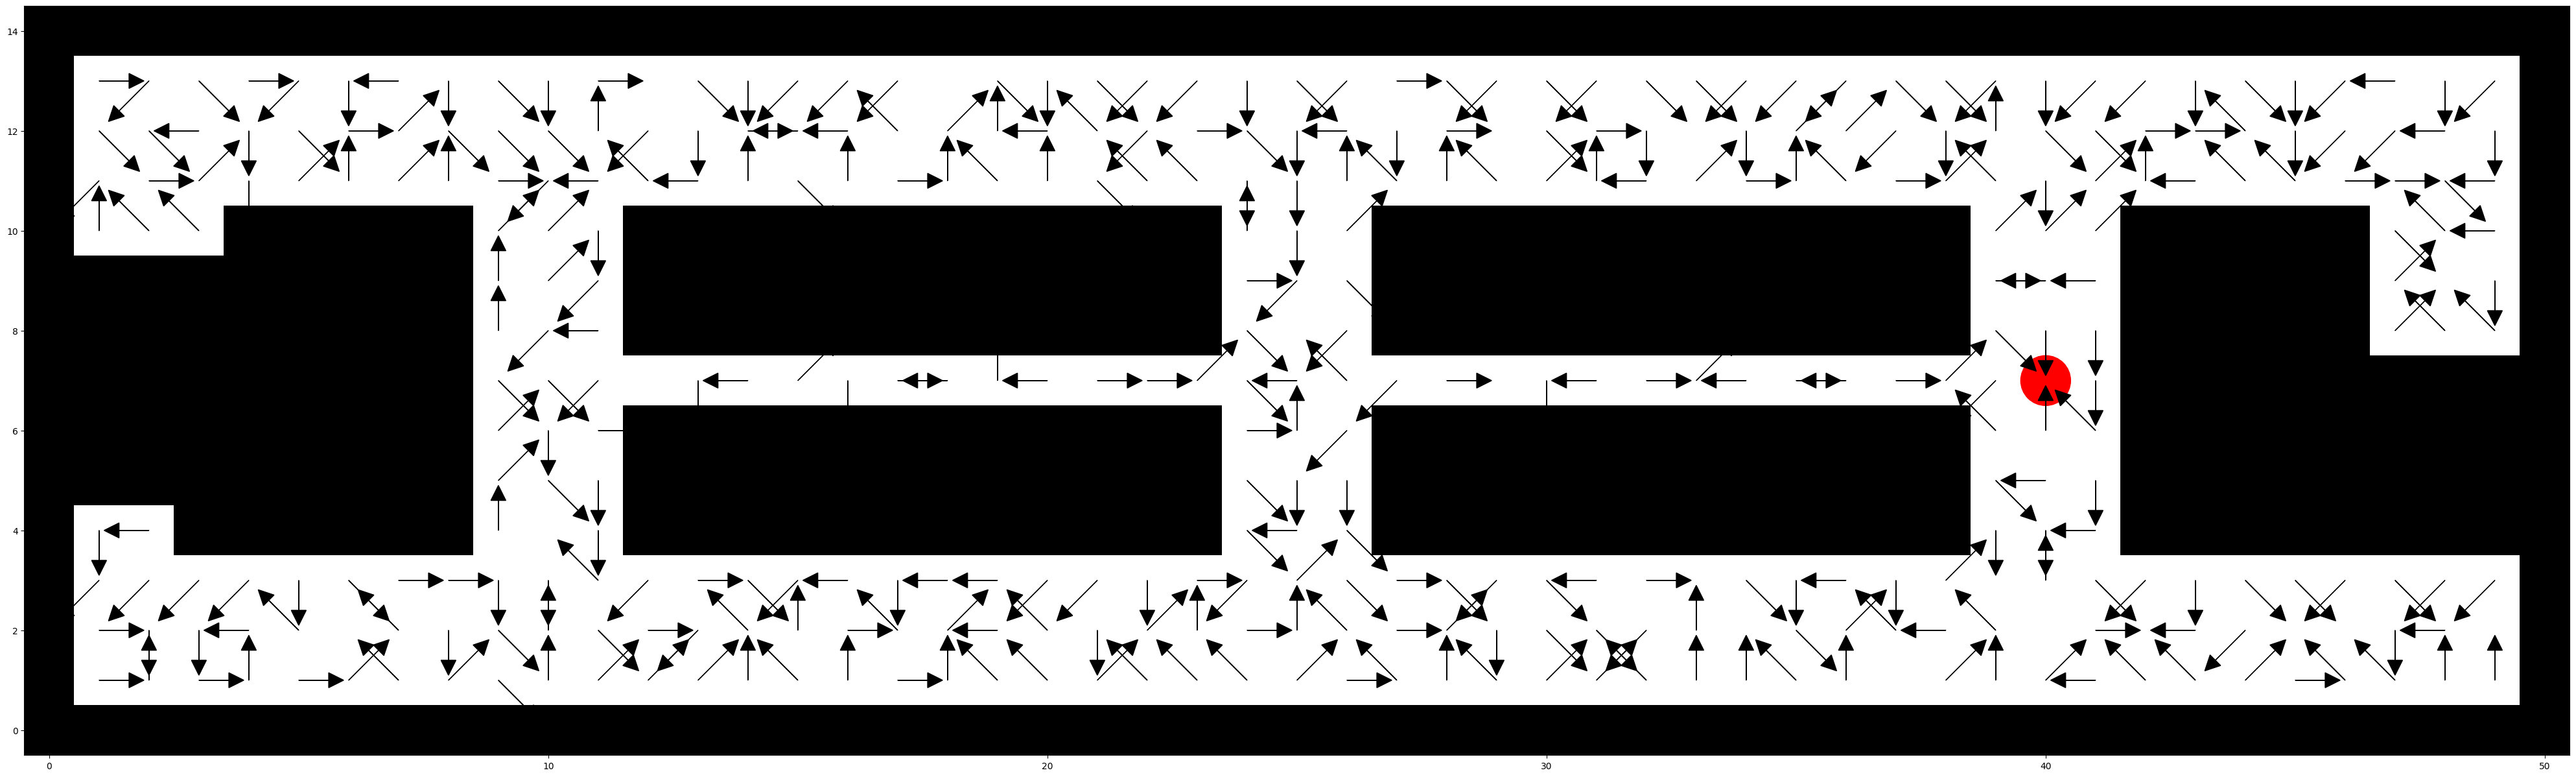

In [11]:
politica_actualizada = obtener_politica(Q_table)
visualiza_politica(politica_actualizada)